# Sandwich Alignment Classifier

## Imports

In [1]:
import os

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision import transforms

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

## Settings & Hyperparameters

In [2]:
IMAGE_RESIZE = (100, 100)
TRAIN_TEST_SPLIT = 0.8
NUM_EPOCHS = 5
BATCH_SIZE = 128
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ENCODING = {'chaotic_evil': 0, 'lawful_evil': 1, 'neutral_evil': 2, 'chaotic_neutral': 3, 'true_neutral': 4, 'lawful_neutral': 5, 'chaotic_good': 6, 'neutral_good': 7, 'lawful_good': 8}

## Dataset

In [3]:
class SandwichDataset(Dataset):
    def __init__(self, image_dir, encoding, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.encoding = encoding
        
        self.image_paths = []
        self.image_labels = []
        for directory in os.listdir(self.image_dir):
            for file in os.listdir(os.path.join(self.image_dir, directory)):
                self.image_paths.append(os.path.join(self.image_dir, directory, file))
                self.image_labels.append(directory)
        

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.encoding[self.image_labels[index]]
        
        return image, label

    def __len__(self):
        return len(self.image_labels)

In [4]:
# Load dataset

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(IMAGE_RESIZE)])

master_dataset = SandwichDataset('sandwiches', encoding=ENCODING, transform=transform)

In [5]:
# Split data

train_size = int(len(master_dataset) * TRAIN_TEST_SPLIT)
test_size = len(master_dataset) - train_size
train_set, valid_set = random_split(master_dataset, [train_size, test_size])

print(f'Train: {len(train_set)}, Test: {len(valid_set)}, Total: {len(train_set) + len(valid_set)}')

Train: 1286, Test: 322, Total: 1608


In [6]:
# Data augmentation on train set

augmented_train_set = []

transform = transforms.Compose([
    transforms.Resize(IMAGE_RESIZE),    
    transforms.RandomRotation(30),
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
])

for _ in range(10):
    augmented_train_set.extend(iter(torch.utils.data.ConcatDataset([train_set])))
    
print(f'Train: {len(augmented_train_set)}, Test: {len(valid_set)}, Total: {len(augmented_train_set) + len(valid_set)}')

Train: 12860, Test: 322, Total: 13182


In [7]:
# Create dataloaders

train_loader = DataLoader(augmented_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [8]:
class ConvNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.layers = torch.nn.Sequential(
                torch.nn.Conv2d(3, 64, kernel_size=3),
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Conv2d(64, 128, kernel_size=3),
                torch.nn.BatchNorm2d(128),
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Conv2d(128, 256, kernel_size=3),
                torch.nn.BatchNorm2d(256),
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Conv2d(256, 32, kernel_size=3, stride=2),
                torch.nn.BatchNorm2d(32),
                torch.nn.LeakyReLU(0.1, inplace=True),
                #
                torch.nn.Flatten(),
                torch.nn.Linear(67712, 128),
                torch.nn.BatchNorm1d(128),
                torch.nn.LeakyReLU(0.1, inplace=True),
                torch.nn.Dropout(0.7),
                #
                torch.nn.Linear(128, num_classes),
                )

    def forward(self, x):
        return self.layers(x)

## Training

In [9]:
model = ConvNet(num_classes=9)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=valid_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=1,
    early_stopping=False)

torch.save(model.state_dict(), 'model.pt')

Epoch: 005/005 | Train: 100.00% | Validation: 36.02%                                                                                                    
Total Training Time: 2.10 min
Test accuracy 36.02%


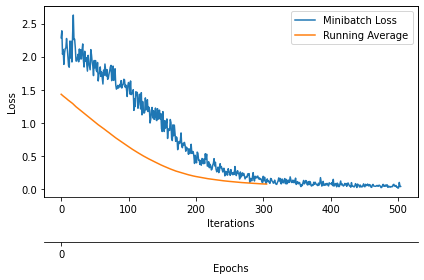

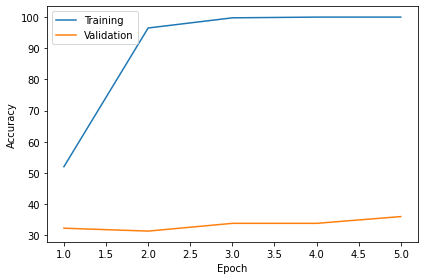

In [10]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.show()

In [11]:
pp=0
for p in list(model.parameters()):
    nn=1
    for s in list(p.size()):
        nn = nn*s
    pp += nn
print(pp)

9114217


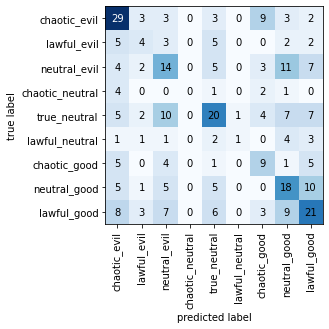

In [12]:
inverted_encoding = {v: k for k, v in ENCODING.items()}
mat = compute_confusion_matrix(model=model, data_loader=valid_loader, device=DEVICE)
plot_confusion_matrix(mat, class_names=inverted_encoding.values())
plt.show()

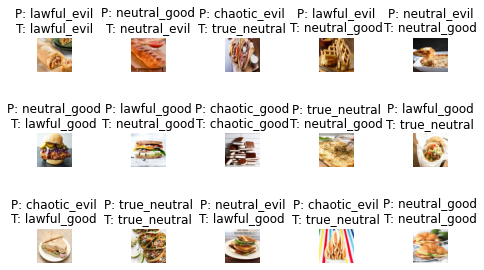

In [13]:
show_examples(model.to(torch.device('cpu')), data_loader=valid_loader, unnormalizer=None, class_dict=inverted_encoding)